# Q-Learning for Temperature Control

In this project, a Q-Learning-based controller is used to regulate a first-order system with time delay (PT1 with delay), which is commonly encountered in temperature control problems.  
This system, although simple, exhibits non-linear behavior due to the delay, making it a good approximation for many real-world control systems, such as temperature control with a single energy capacity (see the section on Control Problem).  
For this temperature control problem, it's easy for a human to visually estimate how close the system's behavior is to the optimal policy by simply examining a plot (see the section on Optimal Policy).
The most common approach for these control problems is a PI or PID controller. Although this works very well, it is __not__ the optimal policy. That means even for a simple control problem like this, machine learning could improve the performance and energy usage of many devices in use today.

In this project, Q-Learning is used to train a neural network to solve the temperature control problem. The controller's performance is compared against both the optimal policy and a PID controller tuned according to standard practices.

Four variants of the Q-Learning algorithm are compared. The first two versions deliver strong results, while the third and fourth are designed with future extensions to (Soft) Actor-Critic methods in mind:

1. Actions are represented by a discrete set of values.
2. Actions are represented by a discrete probability distribution.
3. Actions are represented by continuous values.
4. Actions are represented by a continuous probability distribution.

The files in this project are structured in the following way:
- README.ipynb: Explanation of the project and results
- README.md: Automatically generated with the command `jupyter nbconvert --execute --to markdown README.ipynb`
- Train.ipynb: Code and hyperparameter settings used to train the presented results
- ControlSystem.py: Code to simulate the system response of the control system and the PID-Controller
- QNetwork.py: Implementation of the different Q-Learning Algorithms
- truncated_normal_distribution.py: Code related to the truncated normal distribution. (Used in the Soft Q-Learning version)

This text first describes the theoretical background. Then the different Q-Learning Algorithms are described and the achieved results are shown.
Finally, some ideas for future work are presented.  

## The Control Problem - PT1 with delay

### Example

To illustrate technical terms and other concepts a simple example is used, where a tank is filled with water and the water temperature is regulated by electrical energy.  
The water should be heated to a specific temperature, called __setpoint__, and the actual water temperature is called __process variable__.  
An electrical current flows through a heating coil, where electrical energy is converted into thermal energy. The thermal energy increases the temperature of the water.  
Because the tank is not perfectly isolated, a heat flow is induced by the difference between the temperature of the environment and the water temperature.  

A temperature sensor is used to measure the water temperature, and the signal is fed back into the controller. The __controller__ is a device that decides how much electrical current flows through the coil, based on the value of the process variable and setpoint. 
The electrical current is the __control signal__, which is commonly referred to as __input signal__, because it is the input of the plant.  
The __plant__ is the system that gets regulated (here the water tank combined with the coil).  
The possible values of the input signal are limited. Here the minimum electric current is zero, since the coil cannot cool down the water. The maximum possible current is limited by the source voltage and the coil impedance.  
There could be a delay between the output of the controller and the input signal of the plant. The signal of the temperature sensor could also be delayed by a certain amount of time.  

Some assumptions are made to simplify the mathematical description of the plant.  
Here it is assumed that the temperature sensor, casing and coil have no energy capacity. The temperature change of the water happens completely uniformly and instantly.  
It is also assumed that the heat flow between the water tank and the environment does not change the ambient temperature.  
This is often a good approximation of reality. For example, when the energy capacity of the water is orders of magnitude smaller than the energy capacity of the environment, it is acceptable to assume the ambient temperature remains constant.

Since the change of the water temperature depends on the water temperature itself, a differential equation is needed to describe the plant. The following equation can be used to describe the water temperature.  
Based on the first law of thermodynamics, one can state that the change of the energy stored inside the water, must be equal to the incoming electric power and the power loss due to imperfect isolation.  
The equation is derived by setting the sum of all powers to zero:
$$
C \frac{dT_\text{water}(t)}{dt} = \eta I_{\text{electric}(t)} - hA \left( T_\text{water}(t) - T_{ambient} \right)
$$

Where:
- $T_\text{water}(t)$: water temperature, called process variable (in $°C$)
- $I_{\text{electric}(t)}$: the electric current, called input signal (in $Ampere$)
- $C \frac{dT_\text{water}(t)}{dt}$: time rate of change of the energy stored inside the system (in $Joule\ per\ second$ or $Watt$)
    - $C$: the thermal capacity of the water in the tank (in $Joule\ per\ Kelvin$)
    - $\frac{dT_\text{water}(t)}{dt}$: time rate of change of the water temperature (in $Kelvin$)
- $ \eta I_{\text{electric}(t)}$: electric power heating up the water (in $Volt ⋅ Ampere$ or $Watt$)
    - $\eta$: constant containing the voltage of the source and an efficiency factor (in $Volt$)
- $hA \left( T_\text{water}(t) - T_{ambient} \right)$ heatflow caused by imperfect isolation (in $Watt$)
    - $h$: the heat transfer coefficient (in $Watt / (m^2⋅Kelvin)$)
    - $A$: surface area of the water tank (in $m^2$)
    - $T_{ambient}$: temperature of the environment (in $°C$)
    - $T_\text{water}(t) - T_{ambient}$: the temperature gradient that causes the heat flow (in $Kelvin$)

### PT1

In control theory, the same equation is usually written in a different form, which is shown in the equation below. Only 2 constants are used and the input signal and process variable are unitless.  
Here the process variable $y(t)$ describes the difference between the water temperature and the ambient temperature. The ambient temperature could be added as an offset to avoid this:

$$
\tau \frac{dy(t)}{dt} + y(t) = K u(t)
$$

Where:
- $y(t)$: process variable $y(t) = T_\text{water}(t) - T_{ambient}$
- $u(t)$: input signal $u(t) = I_{\text{electric}(t)}$
- $\tau$: time constant $\tau = \frac{C}{hA}$
- $K$: gain $K = \frac{\eta}{hA}$

The plant described by this equation is commonly referred to as "first order linear time invariant system" or __PT1 system__. The two constants used to describe the system are called __time constant__ $\tau$ (or $T$) and __gain__ $K$.

### Delay

The __PT1 system with delay__ can be described by introducing a __delay__ before the input signal is fed into the PT1 system.
From the perspective of the controller it is equivalent when the measurement of the process variable is delayed instead.  
While the PT1 system itself is linear, the addition of a delay makes the overall system nonlinear.

### Loss function

The __error__ is the difference between the setpoint and the process variable.  

$$
error(t) = setpoint - process\_variable(t)
$$

The __loss function__ describes the goal of an optimization problem. Here, the goal of the controller is to minimize the absolute value of the error.
The loss function is defined as the mean absolute error over time. This loss is used to compare the quality of the different control strategies:

$$
mean\_absolute\_error = \frac{1}{n} \sum_{i=1}^{n} |error(t_i)|
$$

### System for comparison

All control policies are compared for a PT1 system with delay, where:
- time constant $T\ =\ 5\ s$
- gain $K\ =\ 2$
- $delay\ =\ 2\ s$
- time resolution $\Delta t\ =\ 0.1\ s$
- input signal $0 \leq u(t) \leq 1$
- process variable $0 \leq pv(t) \leq 2$ induced by the limitation of the input signal and the gain

Starting from an initial state of zero, each control policy is evaluated for 30 seconds using six setpoints (0.2, 0.5, 0.7, 1.2, 1.5, 1.9). The mean absolute error is used to compare the quality of the result.  

### Step Response

The code below plots the step response of the system where, at time $t = 0$, the input signal changes from zero to one.  
From this plot, the time constant, gain, and delay of the system can be determined.
The gain represents the ratio between the input signal and the final value the process variable reaches when the input signal remains unchanged indefinitely (asymptote).
The delay is the time between the input step and the first observable change in the process variable.
The sum of the time constant and delay represents the time required for the process variable to reach approximately 63.2% ($1 - 1/e$) of the asymptote.

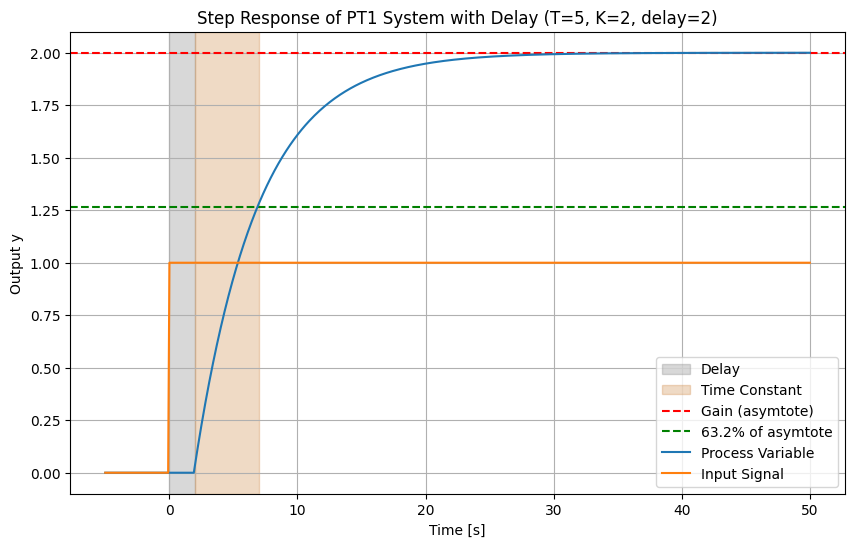

In [5]:
import matplotlib.pyplot as plt
import ControlSystem
import torch

K = 2
T = 5
delay=2
delta_t = 0.1
pt1 = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay, device="cpu")

simulation_time = 50.0
start_time = 5.0
steps = int(simulation_time / delta_t)
start_step = int(start_time / delta_t)
inputs = torch.cat((torch.zeros([start_step]), torch.ones([steps])))
time_values = torch.linspace(-start_time, simulation_time, steps + start_step)
output_values = []

for u in inputs:
    y = pt1.calculate(u).cpu()
    output_values.append(y)

plt.figure(figsize=(10, 6))
plt.axvspan(0.0, delay, color="grey", alpha=0.3, label="Delay")
plt.axvspan(delay, delay + T, color="peru", alpha=0.3, label="Time Constant")
plt.axhline(K, linestyle="--", color="red", label="Gain (asymtote)")
plt.axhline(K * (1.0 - 1.0 / torch.e), linestyle="--", color="green", label="63.2% of asymtote")
plt.plot(time_values, output_values, label=f'Process Variable')
plt.plot(time_values, inputs, label='Input Signal')
plt.title(f'Step Response of PT1 System with Delay (T={T}, K={K}, delay={delay})')
plt.xlabel('Time [s]')
plt.ylabel('Output y')
plt.grid(True)
plt.legend()
plt.show()

### The optimal policy - Time Optimal Control

The __optimal policy__ means the best possible sequence of actions, to achieve a desired result.  
The __time optimal control policy__ brings the system from a state *s* to another state *s'*, (and keeps it in this state) in the shortest possible time.  
For a PT1-System with delay the time optimal policy is also the optimal policy to minimize the previously defined loss function.

Let's first consider the water tank example without delay. The water is at 10°C and should be heated to 65°C.  
The time optimal policy in this case is to initially heat with the maximum possible electric current. When the water temperature reaches 65°C the current is decreased to the value needed to hold the water at exactly 65°C.  
When the delay is introduced, it does not affect the input signal of the optimal policy (in this example). The observed system response is just delayed, which affects feedback-based control strategies.  

In order to generally find the optimal policy for a control problem, the calculus of variations is used. For most complex control systems, solving for the optimal policy is very difficult or even impossible analytically. For this simple control system it is possible to solve, but is outside of the scope of this document. A proof of the optimal solution can be found in the book (Optimal Control: Linear Quadratic Methods" by Brian D. O. Anderson and John B. Moore).  
In real world applications the system parameters can slightly change (wind blowing, sun shining, etc...). Also a control system is usually only approximately described by a mathematical formula, since the real world is too complex when looking at every detail. Therefore, controllers based on optimal control policies are rarely used in practice.  

The plot below shows the optimal policy for reaching different setpoints. The initial state is zero and the input signal is limited to values between 0 and 1. We can calculate the control output to hold the process variable at exactly the setpoint by dividing by the gain: $controlsignal = setpoint / K$. When the system is initially in state 0, we can calculate the time needed to reach the setpoint with the maximum control signal of 1 by: $t_\text{max} = -\tau * ln(1 - setpoint / K)$.

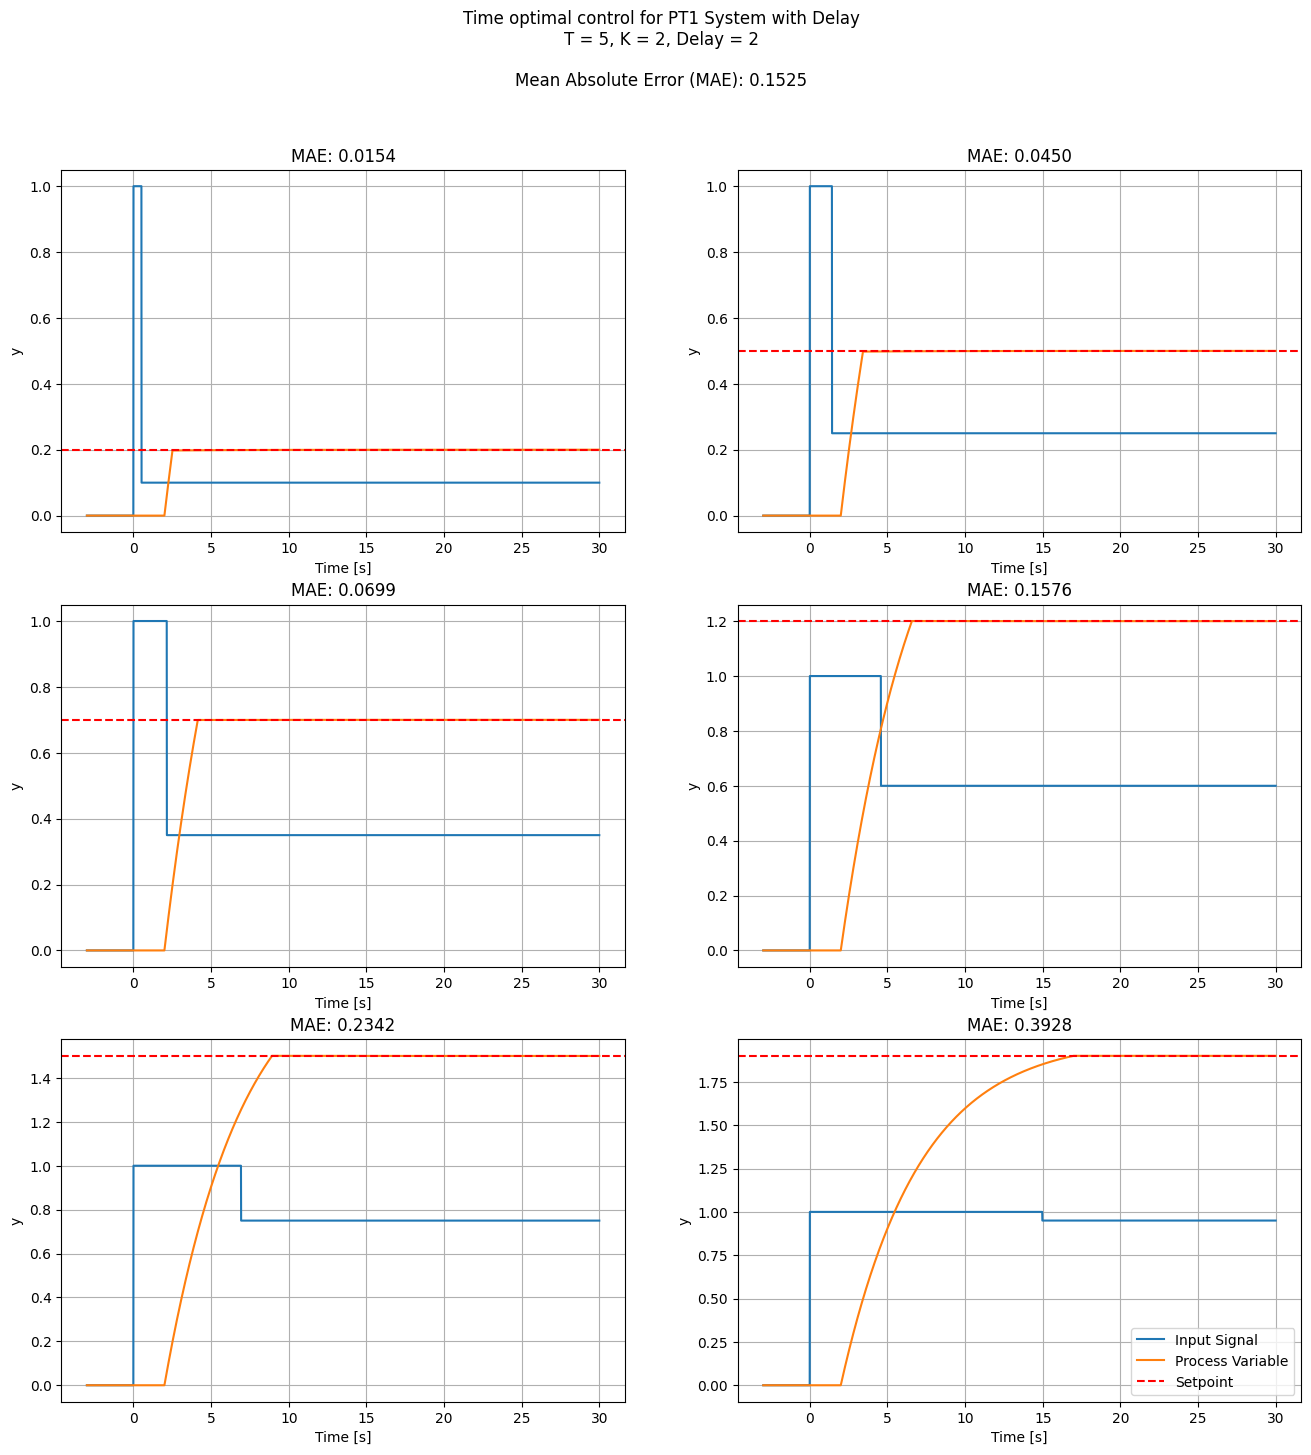

In [7]:
import matplotlib.pyplot as plt
import ControlSystem
import torch

K = 2
T = 5
delay=2
delta_t = 0.01

simulation_time = 30.0
start_time = 3.0
steps = int(simulation_time / delta_t)
start_step = int(start_time / delta_t)
time_values = torch.linspace(-start_time, simulation_time, steps + start_step)
setpoints = [0.2, 0.5, 0.7, 1.2, 1.5, 1.9]

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
i=0
overall_mean_error = 0.0
for setpoint in setpoints:
    ax = axes[i // cols, i % cols]
    i += 1
    pt1 = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay, device="cpu")
    output_values = []
    final_control_output = setpoint / K
    max_heat_time =  - T * torch.log(torch.tensor(1 - setpoint / K))
    max_heat_steps = int(max_heat_time / delta_t)
    inputs = torch.cat((torch.zeros([start_step]), torch.ones([max_heat_steps]), torch.full([steps - max_heat_steps], final_control_output)))
    for u in inputs:
        y = pt1.calculate(u).cpu()
        output_values.append(y)

    valid_pv = torch.tensor(output_values)[time_values >= 0.0]
    mean_error = torch.mean(torch.abs(valid_pv - setpoint))
    overall_mean_error += mean_error / len(setpoints)

    ax.plot(time_values, inputs, label='Input Signal')
    ax.plot(time_values, output_values, label='Process Variable')
    ax.axhline(setpoint, linestyle="--", color="r", label="Setpoint")
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y')
    ax.set_title(f'MAE: {mean_error:5.4f}')
    ax.grid(True)
fig.suptitle(f'Time optimal control for PT1 System with Delay\nT = {T}, K = {K}, Delay = {delay}\n\nMean Absolute Error (MAE): {overall_mean_error:5.4f}')
plt.legend()
plt.show()



## PID-Controller with windup compensation

### PID-Controller

The [PID controller](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller) is used for a wide range of applications. The controller's input is the difference between the process variable and the setpoint, known as error ($e(t)$). The output of the controller is the input signal of the plant ($u(t)$).
The following formula describes the PID-Controller, with three constants ($K_p$, $K_i$ and $K_d$):  

$$
u(t) = K_p e(t) + K_i \int_{0}^{t} e(\tau) d\tau + K_d \frac{d}{dt} e(t)
$$

### Windup Compensation

A commonly used controller in practice is a modified PID controller with [windup](https://en.wikipedia.org/wiki/Integral_windup) compensation. The modification is necessary, because the output of a regular PID controller could be any real number. On the other hand the input signal of the plant is usually limited to a certain range.  
Limiting the output after the PID controller transforms it into a different non-linear system. This breaks the mathematical assumptions used to find good values for the constants (_Kp, Ki and Kd_). While the limitation is active the integral term accumulating inside the controller becomes inaccurate.  
Windup compensation is simply a strategy to address this problem. In the implementation here, as long as the control output needs to be limited, the integral part of the PID controller is not changed.  

### Parameter Tuning

Empirical formulas can be used to determine suitable values for the three constants $K_p$, $K_i$ and $K_d$. The formula used to tune the parameters of the PID controller can be found [here](https://de.wikipedia.org/wiki/Faustformelverfahren_%28Automatisierungstechnik%29).  
The plot below shows the result of using such a PID controller to reach different setpoints for the previously shown system.  
When using a PID controller for this system, it either overshoots or only approaches the setpoint asymptotically. Usually settings are chosen that result in slight overshooting.  
While delay does not affect the optimal policy shown above, a delay negatively affects the performance of the PID controller.

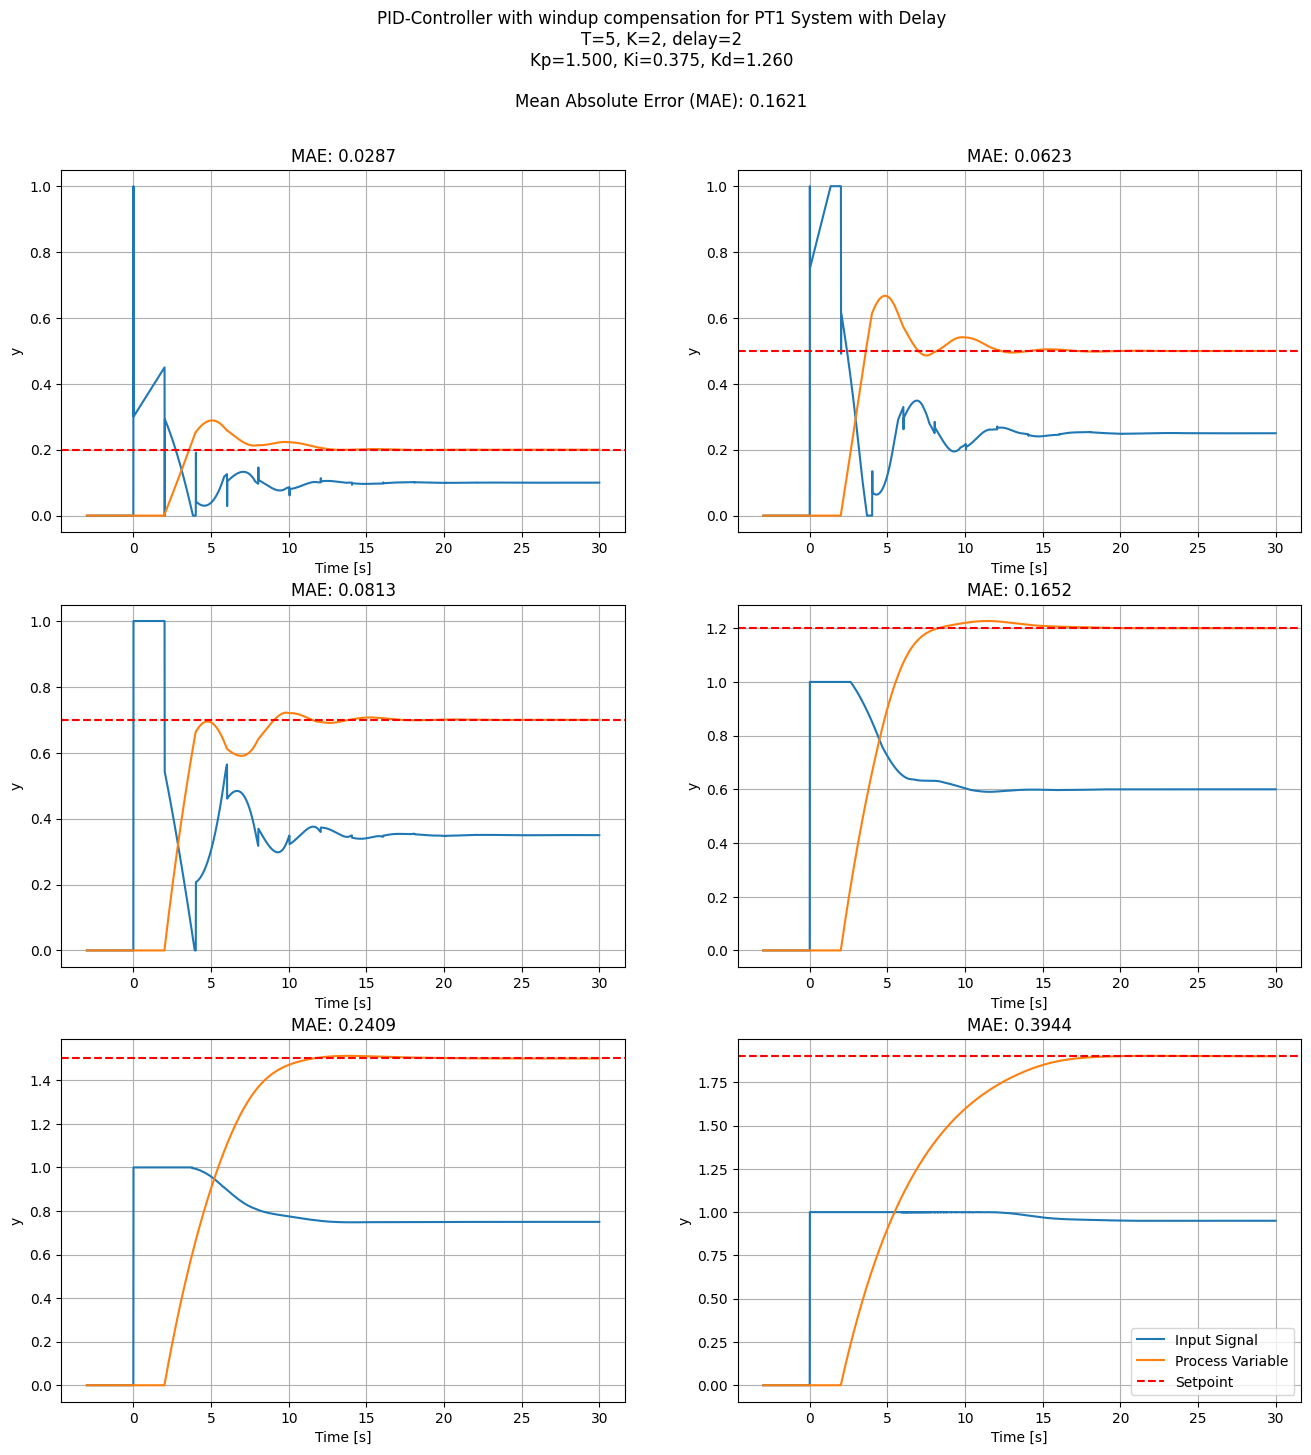

In [6]:
import torch
import matplotlib.pyplot as plt
import ControlSystem

K = 2
T = 5
delay = 2
delta_t = 0.01

# Parameter tuning for the PID-Controller
# https://de.wikipedia.org/wiki/Faustformelverfahren_%28Automatisierungstechnik%29
# Auslegung Chien 20% Störung.
Kp = 1.2 * T / K / delay
Tn = 2 * delay  # Nachstellzeit
Tv = 0.42 * delay # Vorhaltezeit
Ki = Kp / Tn
Kd = Kp * Tv

simulation_time = 30
steps = int(simulation_time / delta_t)
start_time = 3.0
start_step = int(start_time / delta_t)
time_values = torch.linspace(-start_time, simulation_time, steps + start_step)
setpoints = [0.2, 0.5, 0.7, 1.2, 1.5, 1.9]
rows, cols = 3, 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
i=0
overall_mean_error = 0.0
for setpoint in setpoints:
    ax = axes[i // cols, i % cols]
    i += 1
    output_values = [0.0] * start_step
    control_values = [0.0] * start_step
    pid = ControlSystem.PID(Kp=Kp, Ki=Ki, Kd=Kd, delta_t=delta_t, min=torch.zeros([1]), max=torch.ones([1]))
    pt1 = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay, device="cpu")

    for step in range(steps):
        measured_value = pt1.y_prev
        control_signal = pid.calculate(setpoint, measured_value)
        output = pt1.calculate(control_signal)

        output_values.append(output.item())
        control_values.append(control_signal.item())

    valid_pv = torch.tensor(output_values)[time_values >= 0.0]
    mean_error = torch.mean(torch.abs(valid_pv - setpoint))
    overall_mean_error += mean_error / len(setpoints)

    ax.plot(time_values, control_values, label='Input Signal')
    ax.plot(time_values, output_values, label='Process Variable')
    ax.axhline(setpoint, linestyle="--", color="r", label="Setpoint")
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y')
    ax.set_title(f'MAE: {mean_error:5.4f}')
    ax.grid(True)
fig.suptitle(f'PID-Controller with windup compensation for PT1 System with Delay\nT={T}, K={K}, delay={delay}\nKp={Kp:5.3f}, Ki={Ki:5.3f}, Kd={Kd:5.3f}\n\nMean Absolute Error (MAE): {overall_mean_error:5.4f}')
plt.legend()
plt.show()


### Q-Learning

A main difference between using machine learning for control problems compared to tasks like image recognition is that usually in control tasks, the optimal policy is unknown. To train a neural network on a classification problem for example one can provide an image labeled as a "bridge".  
For a control problem on the other hand, the target (or label) isn't directly available and an algorithm is needed that can find the optimal solution. Obviously for the system here, the optimal policy is known, but the goal is to develop an algorithm that can solve more complex problems later.  
[Reinforcement Learning](https://en.wikipedia.org/wiki/Reinforcement_learning) is a machine learning paradigm commonly used to solve these problems. In __reinforcement learning__ an __intelligent agent__ takes __actions__ in a __dynamic environment__ in order to optimize a __reward__.  

[Q-Learning](https://en.wikipedia.org/wiki/Q-learning) is a reinforcement learning algorithm based on the [Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation). The Bellman Equation states, that some optimization problems can be broken down into a sequence of simpler subproblems. For example, if the shortest path between two cities A and B goes through two villages X and Y, then it must also use the shortest path between the two villages. It can be proven that (under certain conditions), the Q-Learning algorithm converges towards the optimal policy [Watkins 1992](https://link.springer.com/article/10.1007/BF00992698#Bib1).  
The beauty of the Q-Learning algorithm lies in the fact that it can solve problems where the reward from an action is delayed across many timesteps, even if only two consecutive timesteps are used during training.

The Q-Learning algorithm updates the Q-value for a state-action pair $(s, a)$ using the following formula:

$$
Q(s_t, a_t)_\text{target} \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha \left[ r_\text{t+1} + \gamma \max_{a_\text{t + 1}} Q(s_\text{t+1}, a_\text{t+1})\right]
$$

Where:
- $Q(s_t, a_t)$ is the current Q-value for the state $(s_t)$ and action $(a_t)$.
- $\alpha$ is the learning rate, $(0 \leq \alpha \leq 1)$.
- $r_\text{t+1}$ is the reward obtained after interaction with the environment
- $\gamma$ is the discount factor, $(0 \leq \gamma \leq 1)$.
- $\max_{a_\text{t + 1}} Q(s_\text{t+1}, a_\text{t+1})$ is the Q-value for the next state $s_\text{t+1}$ under the condition that the best action is chosen.

When the discount factor is set to 1, the Q-Value is the prediction of the sum of all future rewards. This could be used for a game like chess or backgammon, because there is only one reward (win or lose) at the end of the game. If rewards are received at many (or all) timesteps and the discount factor is 1, the Q-Value would approach infinity. The discount factor determines the importance of future rewards, and for a discount factor of zero the agent would only consider current rewards.

The PT1 system with delay is well-suited for testing the performance of Q-Learning algorithms, because the delay parameter exactly matches the delayed reward. A high delay is also often a problem in practice, since it degrades the performance of a PID controller.

### Q-Learning with discrete action space

#### Core Algorithm

This approach is based on the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

As in the mentioned paper, the Q-function is approximated with a neural network. The input of the neural network is a tensor containing all relevant information to describe the current state of the environment. The output is a tensor where each element represents the Q-Value for one discrete action.  
During interaction with the environment, the Q-Network is evaluated for each timestep $\Delta t$ and the best action (highest Q-Value) for the current state *s* is chosen. For exploration during training sometimes a random action is chosen instead (called $\epsilon$-greedy strategy).  
To shuffle the training data, a replay buffer is used instead of immediately training the Q-Network after an interaction with the environment. This allows shuffling the training data, which is essential because training samples of adjacent timesteps are highly correlated.  

#### Modifications

Since the problem here is relatively simple, a fully connected network with 3 Layers and a hidden size of 64 with the ReLU activation function is used. This has the advantage that one can try out different hyperparameters and implementation details quickly.  
The input is a tensor containing a time series of past process variables, input signals as well as the current setpoint.  

The reward is defined as the negative absolute error:
$$
reward(t) = - | error(t) |
$$

#### Results

The following plot shows the result for an agent with 11 discrete actions (0.0, 0.1, ... , 1.0). The mean absolute error of the result slightly outperforms that of the PID controller.

It is clearly suboptimal that the agent switches rapidly between high and low input signals instead of choosing better intermediate values.  
One possible reason could be the $\epsilon$-greedy strategy during training. The agent learns to control the system under the condition that random actions are sometimes taken.  
Another explanation for this behaviour could be a bias in the training data. In the beginning, the behaviour of the agent is random, so the process variable will often be far from the setpoint. In this situation, the best action is to select either the maximum or minimum input signal. That means during a long period at the beginning of training, there is a bias towards the actions at the edge of the interval.


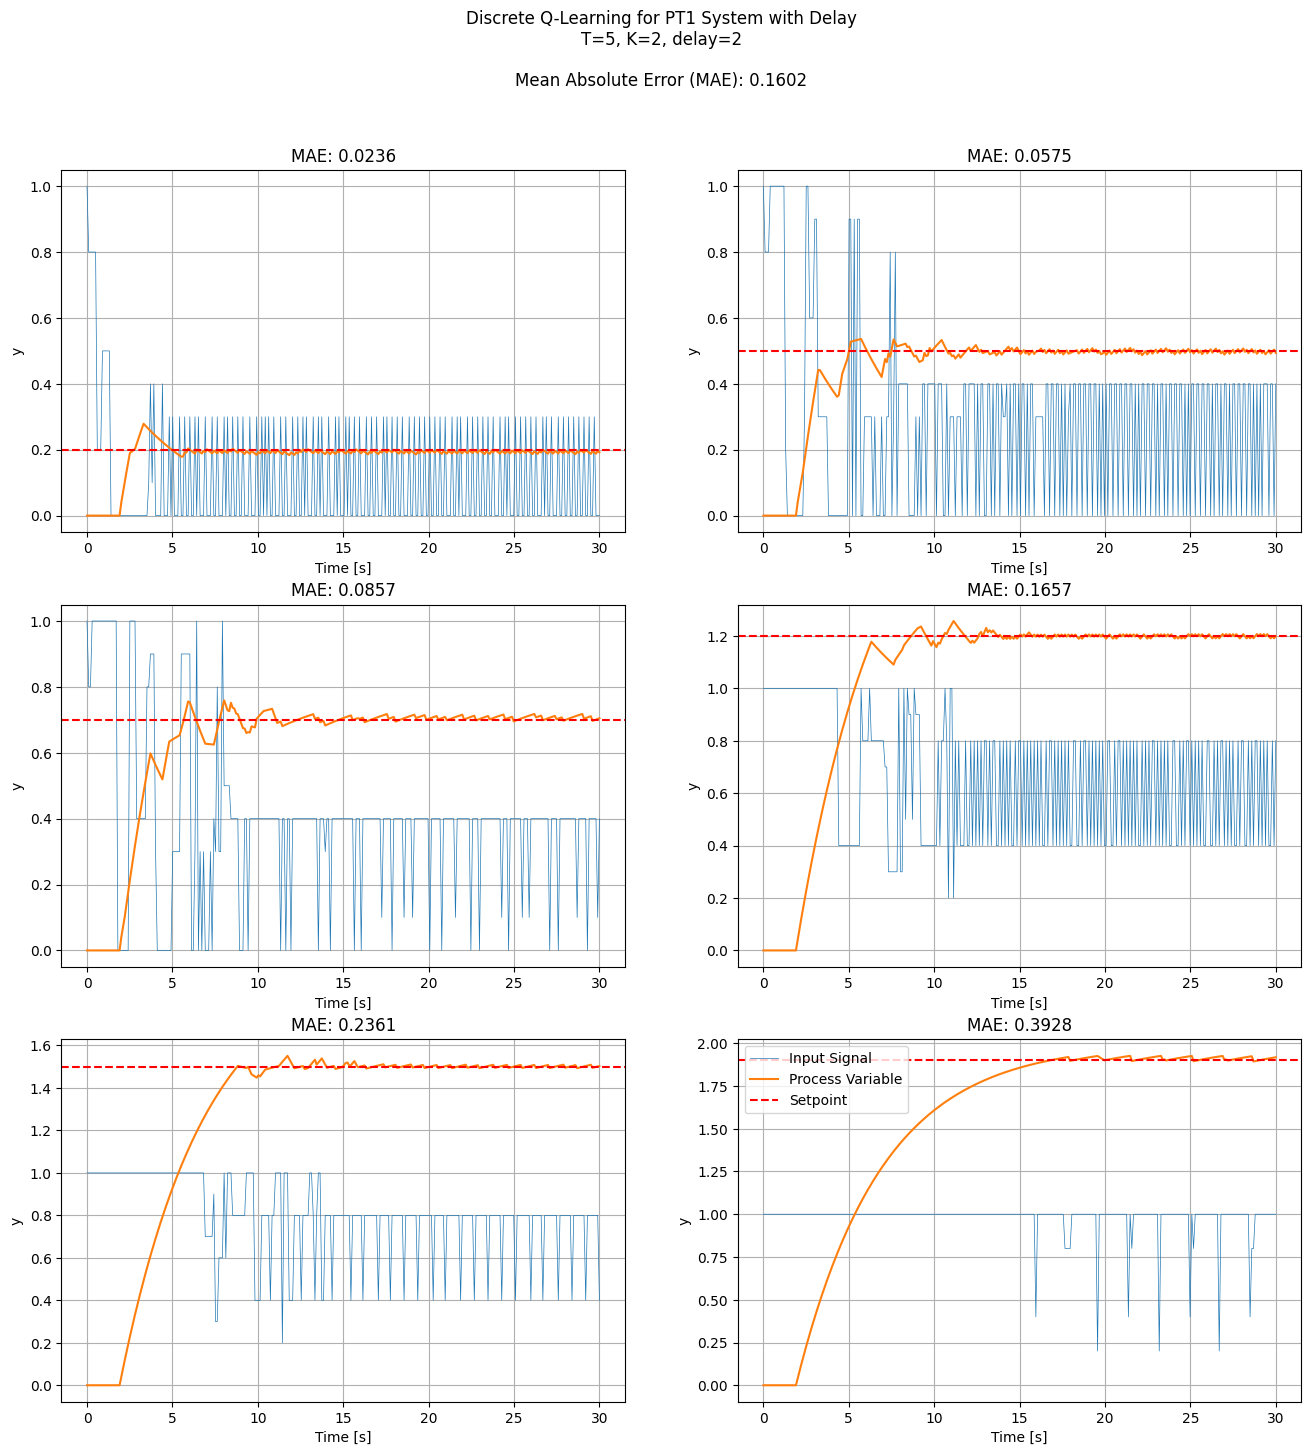

In [90]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import ControlSystem
from QNetwork import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= "qnetwork_11act.pth"
action_size = 11

K = 2
T = 5
delay = 2
delta_t = 0.1

simulation_time = 30
steps = int(simulation_time / delta_t)
time_values = torch.linspace(0.0, simulation_time, steps)
setpoints = [0.2, 0.5, 0.7, 1.2, 1.5, 1.9]
rows, cols = 3, 2

agent = QLearningAgent(action_size=action_size, n=100, gamma=0.988,
                        epsilon=0.0, epsilon_decay=0.99999, epsilon_min=0.08,
                        learning_rate=0.0, warmup_steps=0, learning_rate_decay=0.0,
                        stored_episodes=1, samples_per_episode=steps)
agent.load(model_name)

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
i=0
overall_mean_error = 0.0
for setpoint in setpoints:
    ax = axes[i // cols, i % cols]
    i += 1

    pt1_with_delay = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay)
    state = pt1_with_delay.y_prev
    setpoint = torch.tensor([setpoint], device=device)
    output_values = torch.zeros([steps], device=device)
    control_values = torch.zeros([steps], device=device)

    for step in range(steps):
        action = agent.act(state, setpoint)

        control_signal = action / (action_size - 1)

        output = pt1_with_delay.calculate(control_signal)
        next_state = output

        reward = -torch.abs(next_state - setpoint)
        agent.remember(state, action, reward, setpoint)
        output_values[step] = output
        control_values[step] = control_signal

        state = next_state

    mean_error = torch.mean(torch.abs(output_values - setpoint))
    overall_mean_error += mean_error / len(setpoints)

    ax.plot(time_values, control_values.cpu(), label='Input Signal', linewidth=0.5)
    ax.plot(time_values, output_values.cpu(), label='Process Variable')
    ax.axhline(setpoint.cpu(), linestyle="--", color="r", label="Setpoint")
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y')
    ax.set_title(f'MAE: {mean_error:5.4f}')
    ax.grid(True)
fig.suptitle(f'Discrete Q-Learning for PT1 System with Delay\nT={T}, K={K}, delay={delay}\n\nMean Absolute Error (MAE): {overall_mean_error:5.4f}')
plt.legend()
plt.show()

## Soft Q-Learning

In [Soft Q-Learning](https://arxiv.org/pdf/1702.08165) actions are represented by probability distributions. A random value is then sampled from this probability distribution to determine the specific action. Additionally, a small reward is added depending on the entropy of the selected probability distribution. In information theory, the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) $H(X)$ is a measure of how much information is needed to describe the state of a random variable $X$. In contrast to the previously shown Q-Learning algorithms, the reward in soft Q-Learning is defined as:

$$
r_\text{soft}(a) = r + \beta \mathcal{H}(a)
$$

Where:
- $r_\text{soft}(a)$: The reward in Soft Q-Learning
- $r$: The reward that represents the objective
- $a$: Probability distribution that represents the action selected in the previous timestep
- $\mathcal{H}(a)$: The entropy of the probability distribution
- $\beta$: Is called __temperature__ parameter and determines the relative importance of the entropy term against the reward

By maximizing entropy alongside the objective, the agent is encouraged to maximize the expected reward while acting as randomly as possible. 
This indicates that a state where many actions lead to a good outcome is preferable to one where the same result can only be achieved with very specific actions.  
For example, one can imagine a chess position with approximately 50% winning chances for both sides according to a chess engine. This could be a simple position early in the opening, but it could also be a position where Black is under attack and there is __only one__ possible sequence of moves to survive. For a human, these are very different positions.  
Another benefit is, that rewarding higher entropy encourages exploration.

### Soft Q-Learning with discrete actions

The previously described discrete version can be adapted into a Soft Q-Learning algorithm with minor modifications. In the standard approach, the action with the highest Q-value was selected (greedy strategy), and for exploration, a random action was sometimes chosen.

Now, instead, a probability is calculated for each action in a way that maximizes the weighted average of the Q-values and the entropy of the probability distribution.  
Then, a specific action is sampled according to these probabilities. This process can be expressed by calculating the probabilities $x_1, x_2, …, x_n$​ in such a way that the following formula is maximized:

$$
f(x_1, x_2, \dots, x_n) = \sum_{i=1}^{n} q_i \cdot x_i + \beta \cdot \mathcal{H}(X)
$$

Where:
- $q_i$: The Q-Value of a discrete action i
- $x_i$: The probability of choosing action i
- $\beta$: The temperature parameter

The result of this maximization is the softmax of the Q-values, divided by the temperature. This is analogous to the Boltzmann-Gibbs distribution, where the Q-values correspond to the energy levels of different particle states:

$$
x_i(a_i|s) = \frac{\exp\left(\frac{Q(s, a_i)}{\beta}\right)}{\sum_{j} \exp\left(\frac{Q(s, a_j)}{\beta}\right)} = \text{softmax}(\frac{Q(s, a_i)}{\beta})
$$

The target update of the Q-Learning algorithm must also be modified. Previously, the maximum Q-value of the next state was used to calculate the target,
assuming that the best action (according to the Q-network) would always be selected during interaction with the environment.  
Now, actions are selected according to the calculated probabilities, so the target update must incorporate the weighted average of future Q-values:

$$
Q(s_t, a_t)_{\text{target}} \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \sum_{a_{t+1}} x_i(a_{t+1}|s_{t+1}) Q(s_{t+1}, a_{t+1}) \right]
$$

As described earlier (see the section on Soft Q-Learning), a reward is also added based on the resulting probability distribution and the temperature parameter. This encourages states where multiple actions are viable.  
The temperature parameter for action selection controls exploration during training, while the reward's temperature parameter determines the balance between reducing error and being in states where many actions are valid.

### Results

The results obtained using this approach are slightly better than those achieved with the traditional $\epsilon$-greedy strategy. Training is also much more stable, requiring fewer attempts to achieve optimal results.

During evaluation, the temperature parameter can be adjusted to balance randomness and reward maximization. Alternatively, one can follow the greedy strategy during evaluation.

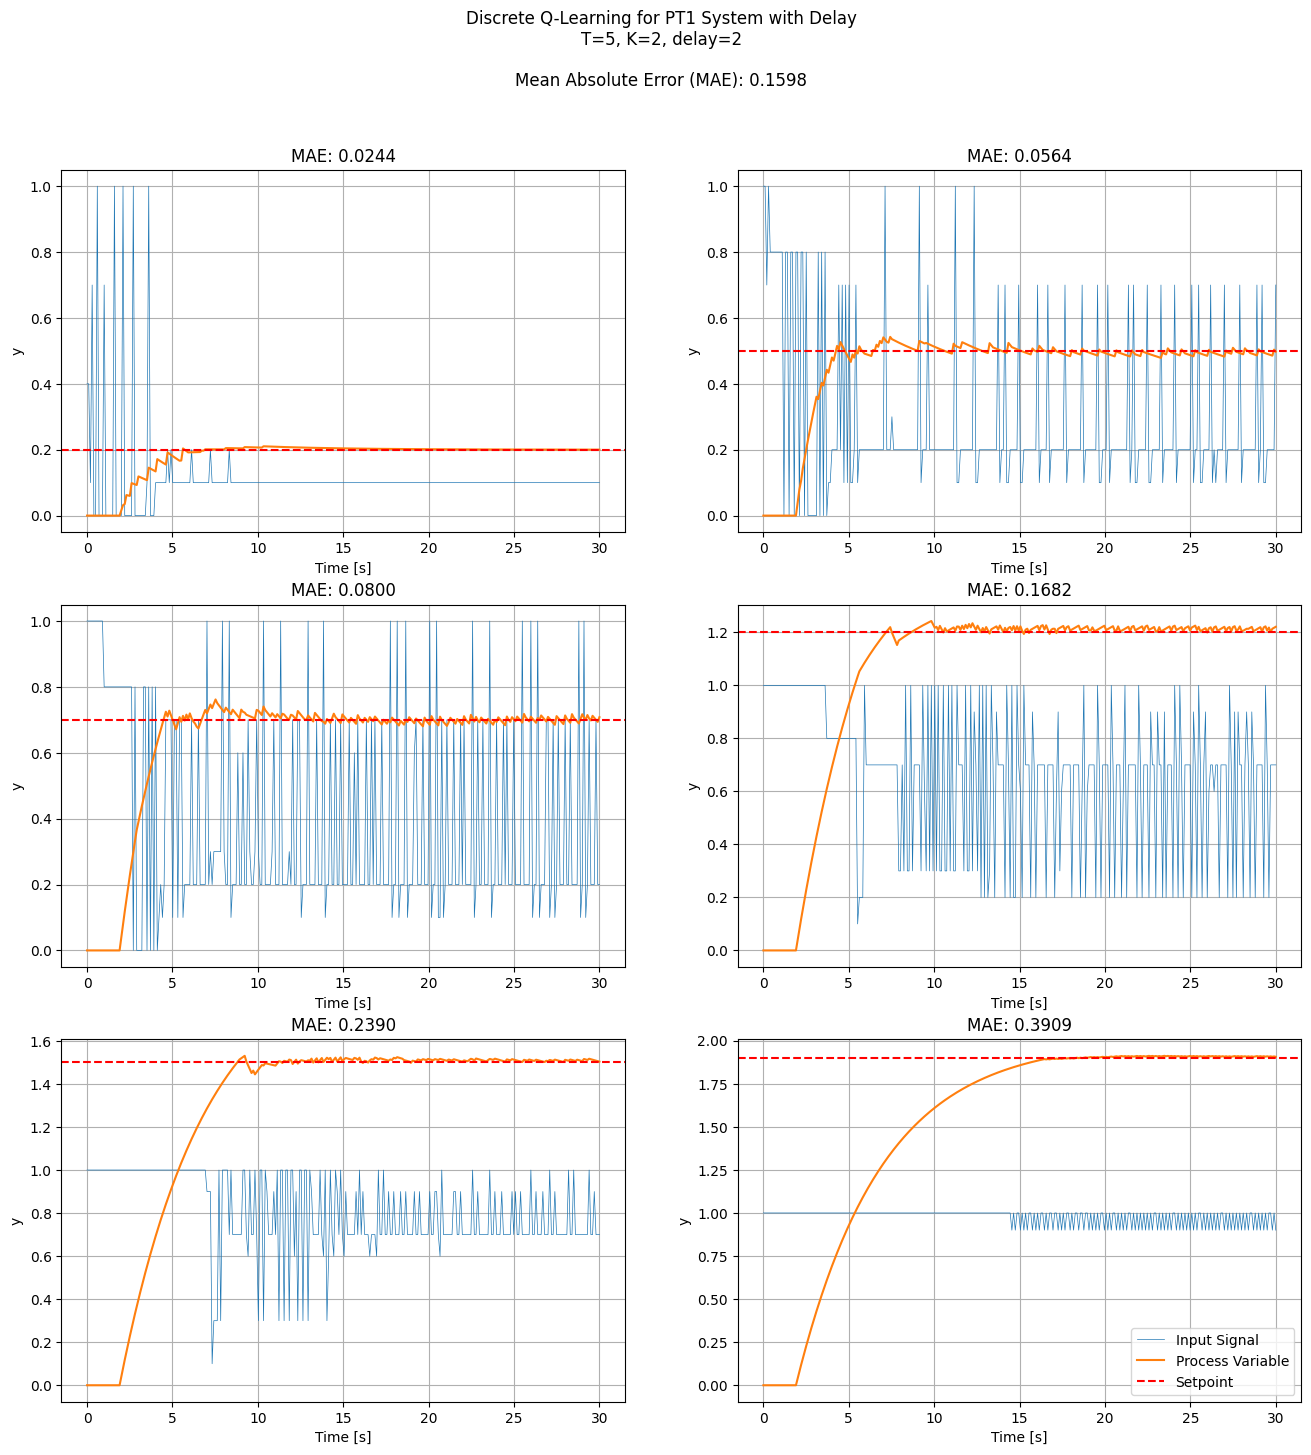

In [99]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import ControlSystem
from QNetwork import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= "qnetwork_11act_boltzmann.pth"
action_size = 11

K = 2
T = 5
delay = 2
delta_t = 0.1

simulation_time = 30
steps = int(simulation_time / delta_t)
time_values = torch.linspace(0.0, simulation_time, steps)
setpoints = [0.2, 0.5, 0.7, 1.2, 1.5, 1.9]
rows, cols = 3, 2

agent = QLearningAgentBoltzmann(action_size=action_size, n=100, gamma=0.988,
                        temperature=0.00001, temperature_decay=0.99999, temperature_min=0.003,
                        learning_rate=0.0, warmup_steps=0, learning_rate_decay=0.0,
                        stored_episodes=1, samples_per_episode=steps)
agent.load(model_name)

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
i=0
overall_mean_error = 0.0
for setpoint in setpoints:
    ax = axes[i // cols, i % cols]
    i += 1

    pt1_with_delay = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay)
    state = pt1_with_delay.y_prev
    setpoint = torch.tensor([setpoint], device=device)
    output_values = torch.zeros([steps], device=device)
    control_values = torch.zeros([steps], device=device)

    for step in range(steps):
        action = agent.act(state, setpoint)

        control_signal = action / (action_size - 1)

        output = pt1_with_delay.calculate(control_signal)
        next_state = output

        reward = -torch.abs(next_state - setpoint)
        agent.remember(state, action, reward, setpoint)
        output_values[step] = output
        control_values[step] = control_signal

        state = next_state

    mean_error = torch.mean(torch.abs(output_values - setpoint))
    overall_mean_error += mean_error / len(setpoints)

    ax.plot(time_values, control_values.cpu(), label='Input Signal', linewidth=0.5)
    ax.plot(time_values, output_values.cpu(), label='Process Variable')
    ax.axhline(setpoint.cpu(), linestyle="--", color="r", label="Setpoint")
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y')
    ax.set_title(f'MAE: {mean_error:5.4f}')
    ax.grid(True)
fig.suptitle(f'Discrete Q-Learning for PT1 System with Delay\nT={T}, K={K}, delay={delay}\n\nMean Absolute Error (MAE): {overall_mean_error:5.4f}')
plt.legend()
plt.show()


## Q-Learning with continuous action space

### Continuous Action Space

In the previously shown Q-Learning Algorithm there is a certain number of discrete actions and the Q-Network outputs the Q-Value for every action.  
Here, a different version is presented where one action is represented by a continuous value.  

Previously the output of the Q-Network contained the Q-Value for each discrete action.
Now, instead, a single continuous action (represented by a floating point value) is part of the input tensor. There is only one element in the output tensor, which is the Q-Value corresponding to the action in the input tensor.  

This raises the question of how to select the best action. Previously one could simply select the discrete action with the highest Q-Value. Now, the best action must be found as it could be any continuous number.  
A brute force algorithm is used to select the best action. The Q-Network is repeatedly evaluated for different random actions, and after a certain number of evaluations (i.e. after predicting the Q-Value of 32 different actions) the action with the highest Q-Value is assumed to be a good enough approximation of the best action.  
Since randomness in the action selection algorithm is assumed to foster exploration, the previously used $\epsilon$-greedy strategy is omited.

### Double Q-Learning

Compared to the previously shown discrete Q-Learning implementation, training turned out to be less stable. One weakness of the Q-Learning Algorithm is, that, in order to determine the target during training, the Q-Networks own prediction of the Q-Value in the next state is used. This makes the algorithm very frail to negative feedback loops. Double Q-Learning addresses this issue (see: [Deep Reinforcement Learning with Double Q-Learning](https://arxiv.org/pdf/1509.06461)). There are different variants of Double Q-Learning, but generally two Q-Networks are used to calculate the next action and the target value for training. In this implementation the action is selected by averaging the outputs of both Q-Networks. The target value for each Q-Network is calculated by averaging the Q-Values for the best future action, as predicted by both networks.

#### Results

The code below shows the result achieved with this implementation. It is clearly worse than the discrete version, but the average error is of a similar magnitude. There is a constant offset between the setpoint and the process variable. While it is certainly possible to improve this result with more hyperparameter tuning and training attempts, more time has already been invested in this implementation compared to the discrete version.

As in the discrete version, the agent alternates between high and low values instead of settling on an intermediate value. This behavior is even more pronounced in the earlier stages of training, where the agent alternates between values close to zero and one, in order to hold the process variable near the setpoint. This aligns with the earlier assumption that, during the early stages of training, there is a bias towards actions at the edges of the interval.

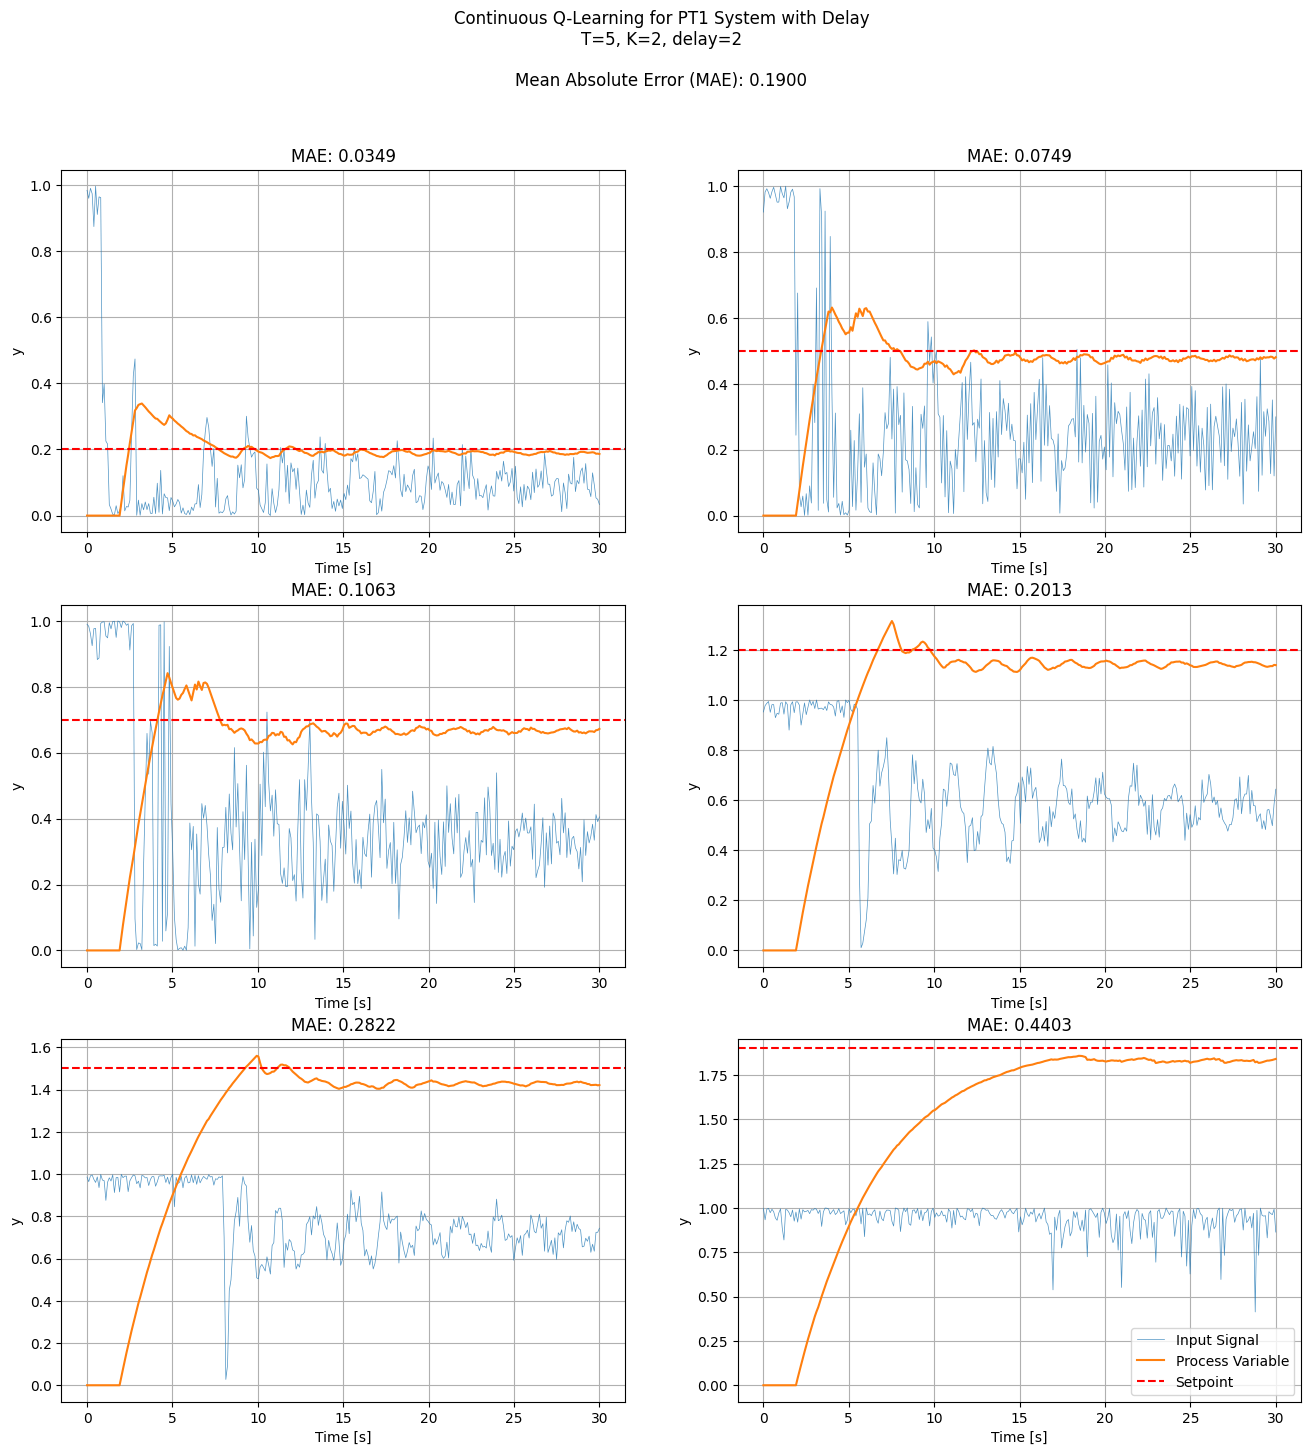

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import ControlSystem
from QNetwork import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = QLearningAgentContinuous(epsilon=0.0, action_search_batch=32)
agent.load("qnetwork_continuous.pth")

K = 2
T = 5 # s
delay = 2 # s
delta_t = 0.1 # s

setpoints = [0.2, 0.5, 0.7, 1.2, 1.5, 1.9]
simulation_time = 30 # s
steps = int(simulation_time / delta_t)
time_values = torch.linspace(0.0, simulation_time, steps)
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
i=0
overall_mean_error = 0.0
for setpoint in setpoints:
    ax = axes[i // cols, i % cols]
    i += 1

    pt1_with_delay = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay)

    output_values = torch.zeros([steps], device=device)
    control_values = torch.zeros([steps], device=device)
    state = pt1_with_delay.y_prev
    setpoint = torch.tensor([setpoint], device=device)
    for step in range(steps):
        control_signal = agent.act(state, setpoint)

        output = pt1_with_delay.calculate(control_signal)
        next_state = output

        output_values[step] = output
        control_values[step] = control_signal

        state = next_state

    mean_error = torch.mean(torch.abs(output_values - setpoint)).cpu()
    overall_mean_error += mean_error / len(setpoints)

    ax.plot(time_values, control_values.cpu(), label='Input Signal', linewidth=0.5, alpha=0.8)
    ax.plot(time_values, output_values.cpu(), label='Process Variable')
    ax.axhline(setpoint.cpu(), linestyle="--", color="r", label="Setpoint")
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y')
    ax.set_title(f'MAE: {mean_error:5.4f}')
    ax.grid(True)
fig.suptitle(f'Continuous Q-Learning for PT1 System with Delay\nT={T}, K={K}, delay={delay}\n\nMean Absolute Error (MAE): {overall_mean_error:5.4f}')
plt.legend()
plt.show()


## Soft Q-Learning with continuous action space

Here, the previously described Q-Learning algorithm for continuous action spaces is modified into a Soft Q-Learning version.

### Truncated normal distribution

Since the controller output must remain within the [0, 1] interval, a truncated normal distribution is used to represent the action.
The truncated normal distribution can be derived from the normal distribution by limiting the random variable to a specified interval, described by the parameters *a* and *b*. The density function is then rescaled.
Unlike in the non-truncated normal distribution, the parameters $\mu$ and $\sigma$ no longer represent the mean and standard deviation
They still describe the position of the maximum of the density function ($\mu$) and the "width" of the density function around the peak ($\sigma$).  
The entropy of this distribution is primarily influenced by the $\sigma$ parameter but also depends on $\mu$. Here, the [differential entropy](https://en.wikipedia.org/wiki/Differential_entropy), as defined by Shannon, is used. Unlike the entropy of a discrete random variable, differential entropy has a different scaling, allowing values smaller than 0.

As in the continuous Q-Learning version a simple brute force algorithm is used to approximate the best action. A probability distribution is generated by selecting random values for $\sigma$ and $\mu$.  
The code below plots a batch of 32 randomly generated probability distributions, which is the size used for the brute force algorithm. These distributions offer a choice between low-entropy distributions for specific mean values (to select a specific value with high probability) and others with high entropy.

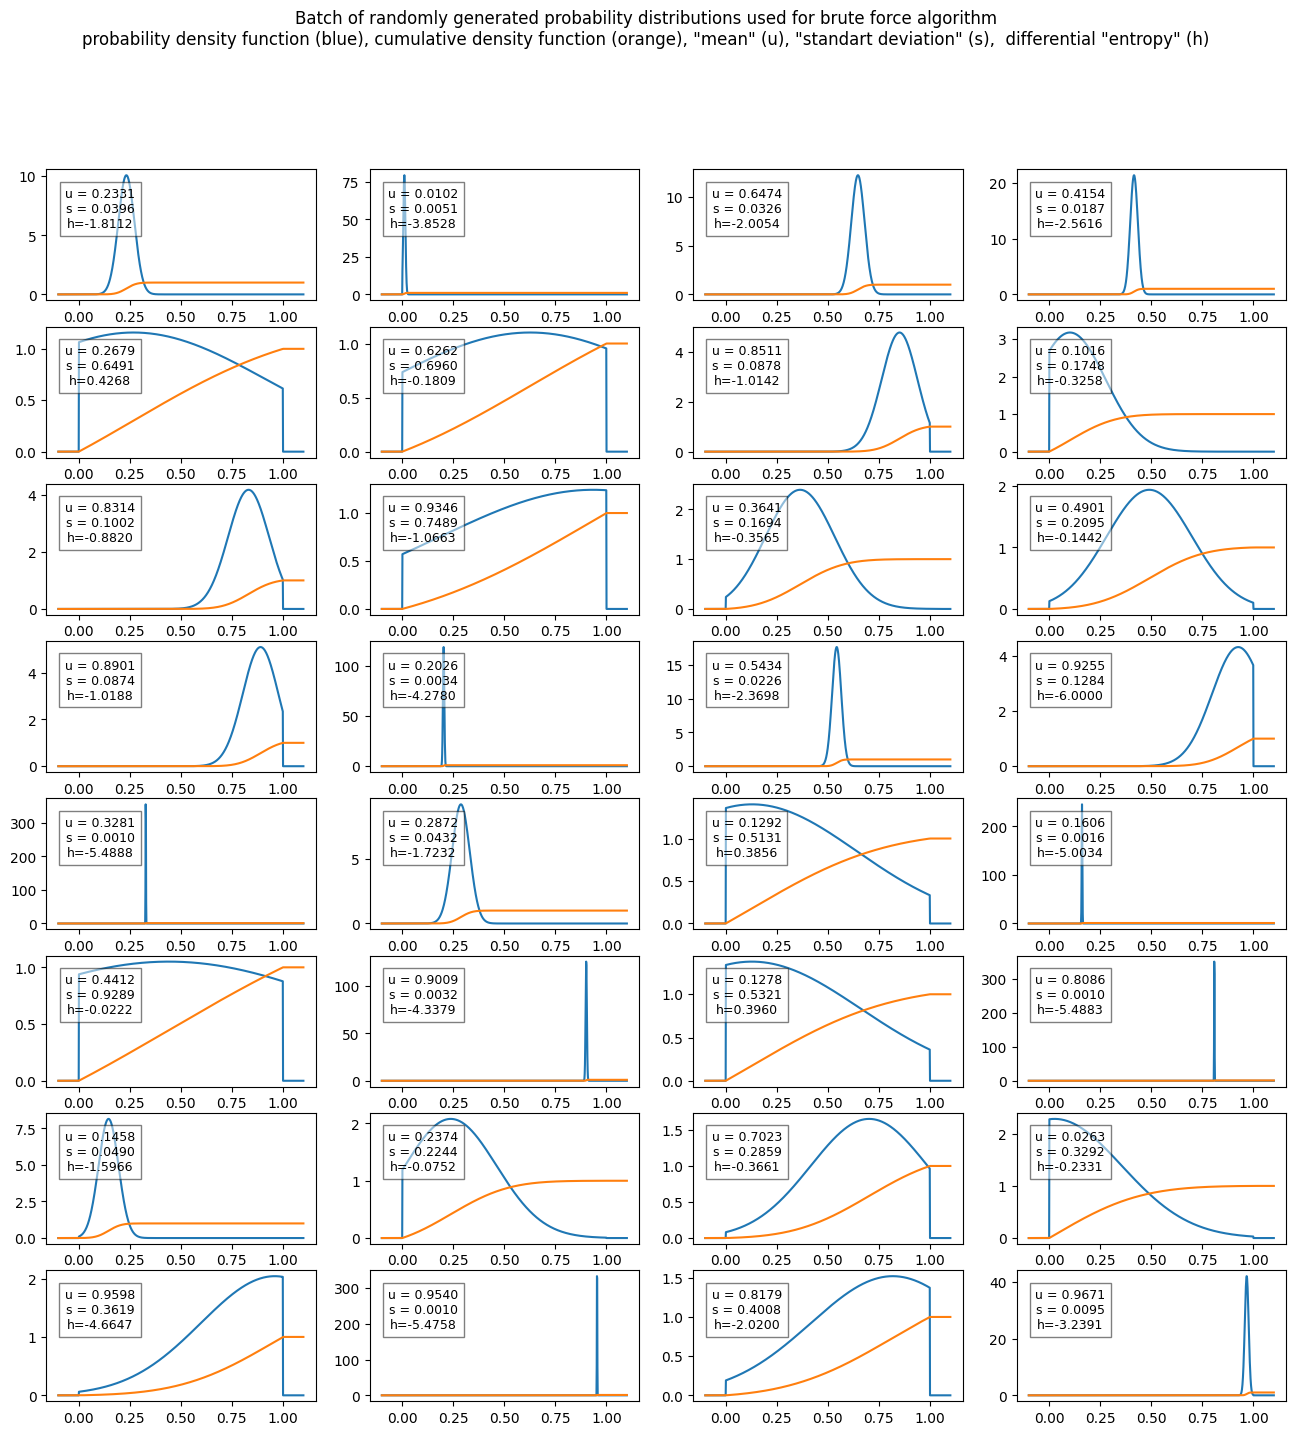

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from truncated_normal_distribution import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start = -0.1
stop = 1.1

n_points = 1000

x = torch.linspace(start, stop, n_points, device=device)

z = torch.tensor([0.0], device=device)
a = torch.tensor(0.0, device=device) # lower bound
b = torch.tensor(1.0, device=device) # upper bound

rows, cols = 8, 4

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))


for i in range(32):
    ax = axes[i // cols, i % cols]
    u = torch.rand([1], device=device)
    s = torch.rand([1], device=device)**4 + 0.001 # more distributions with low variance. variance cannot be 0
    y = truncated_normal_density(u, s, a, b, x)
    cmd = truncated_normal_cmd(u, s, a, b, x)
    ax.plot(x.cpu(), y.cpu())
    ax.plot(x.cpu(), cmd.cpu())
    ax.text(0.2,0.7,f"u = {u.item():6.4f}\ns = {s.item():6.4f}\nh={truncated_normal_entropy(u, s, a, b).item():6.4f}", transform=ax.transAxes,
            fontsize=9, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

fig.suptitle('Batch of randomly generated truncated normal distributions used for brute force algorithm\nprobability density function (blue), cumulative density function (orange), "mean" (u), "standard deviation" (s),  differential "entropy" (h)')
plt.show()

## Continuous Soft Q-Learning Results

The next code cell shows the results for the agent based on Soft Q-Learning. The plot now contains the values of $\mu$ and $\sigma$ that define the truncated normal distribution from which the input signal is sampled.  

The agent clearly converged toward the expected behavior, which - derived from the knowledge of the optimal policy - can be described as follows.  
Initially, it should heat up quickly by selecting high values of $\mu$ ("mean") and low values of $\sigma$ ("standard deviation"). This results in the fastest possible heat up, because input signals close to 1 are chosen with a high probability.  
When the process variable approaches the setpoint, one would expect the agent to select higher values for $\sigma$. This is expected because it leads to a reward for higher entropy.  
When the setpoint is close to zero or two, the agent needs to consistently produce values near the boundary of the interval of the input signal. Therefore the agent must select low values for the parameter $\sigma$.

In the plot below, the number of searches for the brute force algorithm was increased by 4 times (128 instead of 32 during training).  
With only 32 searches a mean absolute error of 0.189 was achieved. The setpoint of 1.9 is never reached because the agent struggles to consistently generate signals near the interval boundary.
The improvement in results when increasing the number of searches during evaluation suggests that the network did not overfit with respect to the number of searches used for action selection.

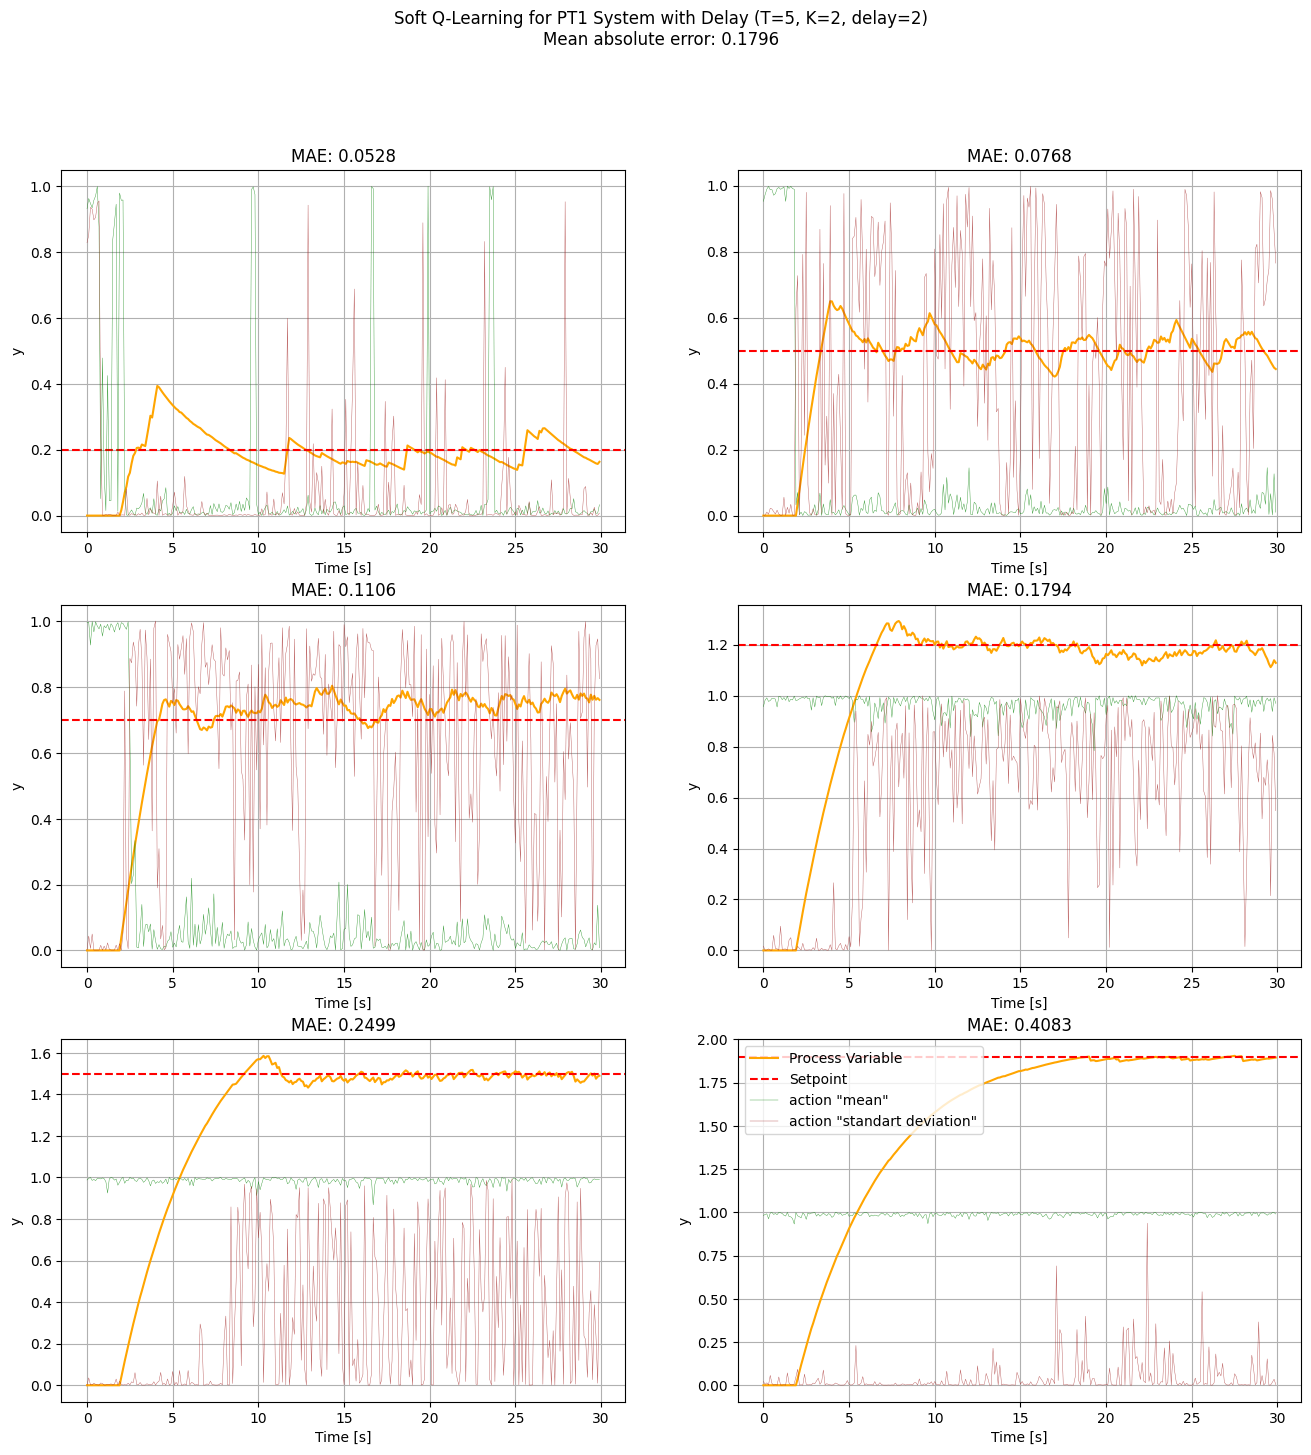

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import ControlSystem
from QNetwork import *

agent = QLearningAgentSoft(action_search_batch=128)
agent.load("qnetwork_soft.pth")
K = 2
T = 5 # s
delay = 2 # s
delta_t = 0.1 # s

setpoints = [0.2, 0.5, 0.7, 1.2, 1.5, 1.9]
simulation_time = 30 # s

steps = int(simulation_time / delta_t)
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
i=0
overall_mean_error = 0.0
for setpoint in setpoints:
    ax = axes[i // cols, i % cols]
    i += 1

    pt1_with_delay = ControlSystem.PT1(K=K, T=T, delta_t=delta_t, delay=delay)

    time_values = torch.zeros([steps], device=device)
    output_values = torch.zeros([steps], device=device)
    control_values = torch.zeros([steps], device=device)
    u_values = torch.zeros([steps], device=device)
    v_values = torch.zeros([steps], device=device)

    state = pt1_with_delay.y_prev
    setpoint = torch.tensor([setpoint], device=device)
    for step in range(steps):
        control_signal, u, v = agent.act(state, setpoint)
        output = pt1_with_delay.calculate(control_signal)
        next_state = output

        time_values[step] = step * delta_t
        output_values[step] = output
        control_values[step] = control_signal
        u_values[step] = u
        v_values[step] = v

        state = next_state

    mean_error = torch.mean(torch.abs(output_values - setpoint)).cpu()
    overall_mean_error += mean_error / len(setpoints)

    time_values = time_values.cpu()
    #ax.plot(time_values, control_values, label='Input Signal', linewidth=0.5)
    ax.plot(time_values, output_values.cpu(), label='Process Variable', color="orange")
    ax.axhline(setpoint.cpu(), linestyle="--", color="r", label="Setpoint")
    ax.plot(time_values, u_values.cpu(), label='action "mean"', linestyle='-', color="green", linewidth=0.5, alpha=0.8)
    ax.plot(time_values, v_values.cpu(), label='action "standard deviation"', linestyle='-', color="brown", linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('y')
    ax.set_title(f'MAE: {mean_error:5.4f}')
    ax.grid(True)
fig.suptitle(f'Soft Q-Learning for PT1 System with Delay (T={T}, K={K}, delay={delay})\nMean absolute error: {overall_mean_error:5.4f}')
plt.legend()
plt.show()


## Outlook

The discrete Q-Learning agent shown slightly outperformed the PID controller, even though it uses only 11 discrete actions.
In applications where the PID controller cannot be used, for example, when a discrete control signal is required and there is a penalty for switching control signals, Q-Learning could potentially offer significantly better performance compared to commonly used control strategies (e.g., multi-position controller).  
The motivation for the Continuous and Soft Q-Learning versions was to later extend the implementation to Actor-Critic methods. 

### Soft Actor-Critic

Instead of using brute force to approximate the best action, a second neural network can be used to select the action. 
Algorithms based on this idea are called [Actor-Critic Algorithms](https://proceedings.neurips.cc/paper_files/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf).  
[Soft Actor-Critic](https://arxiv.org/pdf/1801.01290) is a state-of-the-art reinforcement learning algorithm that combines this approach with Soft Q-Learning.  
The next step is to modify the previously demonstrated Soft Q-Learning version and implement an agent based on the Soft Actor-Critic Algorithm. 

The truncated normal distribution used in the Soft Q-Learning version has the interesting property that it remains a valid probability distribution when the parameter $\sigma^2$ (the variance of the normal distribution) is negative.
However, computations with complex numbers would be required, which the current implementation does not support.  
For negative $\sigma^2$, the probability density function of the truncated normal distribution looks like an "inversion", where the parameter $\mu$ (the mean of the normal distribution) describes the minimum instead of the maximum of the density function.  
For Actor-Critic Algorithms, this could be useful because it is not necessary to restrict the value of this parameter to positive numbers.  
It is also more expressive, since the agent could show an intent to avoid a specific value for the control signal.

### Soft Actor-Critic with Multiple control signals

Control systems that require multiple control signals are especially challenging (for example a humanoid robot with many motors).
The previously mentioned Soft Actor-Critic Algorithm improved the state of the art for a robot with 21 motors.
It makes sense to extend the implementation of the Soft Actor-Critic version to support multiple control signals.  
For control problems with multiple control signals, a separate probability distribution can describe the action for each control signal.  
Alternatively, a multivariate probability distribution could be used to sample all actions.
Another approach could be to describe an action using multiple probability distributions and combine the results (e.g., through convolution).

### Improve multi-position controller

An example where a PID-Controller cannot be used, and the discrete Q-Learning version seems promising could be the following.
In family homes, hot water is often provided by a water boiler heated with oil or gas.
The burner could operate in two stages, resulting in three possible actions: 0%, 50%, and 100% power.
Interpolating values between these stages using PWM is not feasible because it would wear down the mechanical components involved in switching, making the PID controller unsuitable.  
A commonly used control strategy for a [three-position controller](https://en.wikipedia.org/wiki/Double-setpoint_control) is to define two threshold values.
When the water temperature falls below the first threshold, the burner operates at 100% power. Between the two thresholds, it operates at 50%, and when the temperature exceeds the second threshold, the burner is turned off.
If the goal is to maintain the water temperature above 65°C (to kill bacteria) while minimizing energy consumption, a more effective control policy could likely be achieved using Q-Learning.
The discrete Q-Learning version could use a modified reward function that imposes a penalty for switching the input signal

### Transfer Learning - Fine Tuning

If the system is known to be a PT1 system with delay, the constants can be estimated using a time series of past input signals and process variable values (see the Step Response section).
Since this information is already present in the input of the neural network, it may be possible to train the same network on various system parameters.
This approach would also enable the use of a pretrained model, which could later be fine-tuned for the specific system’s parameters.